# **Example GeoPolRisk | Use case 2**

**Authors:**  
[Romain Sacchi](mailto:romain.sacchi@psi.ch)  
[Alvaro Hahn Menacho](mailto:alvaro.hahn-menacho@psi.ch)


This notebook presents an example to obtain an exchange-based LCA score using the [GeoPolRisk 1.0](https://doi.org/10.1016/j.resconrec.2024.107801) method.  
This example is part of the following publication:

**Sacchi, R., Menacho, A. H., Seitfudem, G., Agez, M., Schlesinger, J., Koyamparambath, A., Saldivar, J. S., Loubet, P., & Bauer, C.** (2025). *Contextual LCIA Without the Overhead: An Exchange-based Framework for Flexible Impact Assessment.*  
International Journal of Life Cycle Assessment.


## Structure

1. [Import *edges* and set *bw2 project*](#sec_import_edges)
2. [Import hydrogen production, PEM, LCI](#sec_import_h2)
3. [Select *Functional Unit* and *method*](#sec_select_fu)
4. [Run edges based LCA](#sec_run_edges_lca)
5. [Export results](#sec_export_results)
6. [Plot results](#sec_plot_results)

<a id="sec_import_edges"></a>
# 1. Import edges and set bw2 project

In [1]:
from edges import EdgeLCIA, get_available_methods, setup_package_logging
import logging
import bw2data, bw2io

# we want the logger to log things into edges.log
setup_package_logging(level=logging.INFO)
# if you want full debug:
#setup_package_logging(level=logging.DEBUG)

/opt/homebrew/Caskroom/miniforge/base/envs/bw25/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


13:06:37+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


For our example, we activate a ``brighway`` project that contains ecoinvent 3.10 cut-off.

In [2]:
bw2data.projects.set_current("bw25_ei310")

<a id="sec_import_h2"></a>
# 2. Import hydrogen production, PEM, LCI

To illustrate our water footprint case, we need to import some inventories representing the production of hydrogen using a PEM electrolyzer, powered with offshore wind power in France. The inventories are provided in this repository (``lci-hydrogen-electrolysis-ei310.xlsx``).

In [4]:
if "h2_pem" in bw2data.databases:
    del bw2data.databases["h2_pem"]
lci = bw2io.ExcelImporter("lci-hydrogen-electrolysis-ei310.xlsx")
lci.apply_strategies()
lci.match_database(fields=["name", "reference product", "location"])
lci.match_database("ecoinvent-3.10-cutoff",fields=["name", "reference product", "location"])
lci.match_database("biosphere",fields=["name", "categories"])
lci.statistics()
lci.drop_unlinked(i_am_reckless=True)
if len(list(lci.unlinked)) == 0:
    lci.write_database()

# we assign manually classifications to activities
# since it is unclear how to do that in the Excel inventory file.

classifications = {
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from solar photovoltaic electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from onshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from geothermal electricity": ("CPC", "34210"),
    "electrolyzer production, 1MWe, PEM, Stack": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer stack, 1MWe, PEM": ("CPC", "3830"),
    "electrolyzer production, 1MWe, PEM, Balance of Plant": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer balance of plant, 1MWe, PEM": ("CPC", "3830"),
    "platinum group metal, extraction and refinery operations": ("CPC", "2420"),
    "deionized water production, via reverse osmosis, from brackish water": ("CPC", "34210")
}
for ds in bw2data.Database("h2_pem"):
    if ds["name"] in classifications:
        ds["classifications"] = [classifications[ds["name"]]]
        ds.save()
    

Extracted 1 worksheets in 0.05 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.12 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Graph statistics for `h2_pem` importer:
11 g

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 497.49it/s]

11:03:10+0200 [info     ] Vacuuming database            


Created database: h2_pem


<a id="sec_select_fu"></a>
# 3. Select Functional Unit and method

### 3.1. Select FU
We select the activity to run the LCA for. In our case, it is the production of 1 kg of hydrogen, using a PEM electrolyzer, powered with offshore wind power, in France.

In [3]:
act = [a for a in bw2data.Database("h2_pem") if a["name"] == "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity"][0]
act

'hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity' (kilogram, FR, None)

### 3.2. Select method

``edges`` comes with a numbers of LCIA methods. You can list them using the `get_available_methods()` function.
We currently have four flavors of `GeoPolRisk 1.0`:

* 'GeoPolRisk', 'elementary flows', '2024': this is a non-regionlaized method that characterizes elementary flows representing resource extraction. This follows the implementation proposed in [Koyamparambath et al., 2024](https://doi.org/10.1016/j.resconrec.2024.107801).
* 'GeoPolRisk', 'paired', '2024': this is a regionalized implementation developed in [Sacchi et al., 2025]() which targets intermediate product exchanges between specific locations instead.


For more information about its implementation and use, refer to [the page about](https://edges.readthedocs.io/en/latest/methods.html#geopolrisk-1-0) `GeoPolRisk` in the ``edges`` documentation, and for more information about the AWARE method itself, refer to:

**Anish Koyamparambath, Philippe Loubet, Steven B. Young, Guido Sonnemann**,  
*Spatially and temporally differentiated characterization factors for supply risk of abiotic resources in life cycle assessment*,  
Resources, Conservation and Recycling, 2024.  
https://doi.org/10.1016/j.resconrec.2024.107801



In [4]:
get_available_methods()

[('AWARE 2.0', 'Country', 'all', 'yearly'),
 ('AWARE 2.0', 'Country', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'non', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'unspecified', 'yearly'),
 ('GeoPolRisk', 'elementary flows', '2024'),
 ('GeoPolRisk', 'paired', '2024'),
 ('ImpactWorld+ 2.1', 'Freshwater acidification', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater acidification', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, long term', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, long term', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, short term', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, short term', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Land occupation, biodiversity', 'damage'),
 ('Im

In [5]:
method = ('GeoPolRisk', 'paired', '2024')
method_alt = ('GeoPolRisk', 'elementary flows', '2024')

<a id="sec_run_edges_lca"></a>
# 4. Run edges-based LCA

In [6]:
%%time
# we instantiate EdgeLCIA, which builds on the `bw2calc.LCA` class
LCA = EdgeLCIA({act: 1}, method)

# we solve the system
LCA.lci()

/opt/homebrew/Caskroom/miniforge/base/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


CPU times: user 2.25 s, sys: 253 ms, total: 2.5 s
Wall time: 2.28 s


`.map_exchanges()` will try to find direct matches based on the criteria listed in the LCIA file.

In [7]:
LCA.map_exchanges()

Mapping exchanges: 100%|█████████████████| 40362/40362 [02:07<00:00, 315.72it/s]


The four following functions are specific to regionalized LCIA methods (which is the case here).

* ``map_aggregate_locations()``: It computes weighted averages for composite regions using a user-specified weighting variable (e.g., population, GDP, resource use) from the method metadata, e.g., RER.
* ``map_dynamic_locations()``: Handle location-matching for dynamic or relative regions such as ‘RoW’ or ‘RoE’.
* ``map_contained_locations()``: Resolve unmatched exchanges by assigning CFs from spatially containing regions (e.g., "CA-QC" will be given the CF for "CA")
* ``map_remaining_locations_to_global()``: Assign global fallback CFs to exchanges that remain unmatched after all regional mapping steps.

In [8]:
LCA.map_aggregate_locations()
LCA.map_dynamic_locations()
LCA.map_contained_locations()
LCA.map_remaining_locations_to_global()

Processing static groups (pass 2): 100%|██████| 262/262 [00:02<00:00, 88.64it/s]
US-PR not found in regex
IN-DD not found in regex
Processing global groups (pass 2): 100%|████████| 76/76 [00:10<00:00,  6.96it/s]


In [9]:
LCA.evaluate_cfs()
LCA.lcia()
current_score = LCA.score
print(current_score)
df_table = LCA.generate_cf_table(include_unmatched=True)

0.38621882672555785


#### Run alternative method
Let's compare with hte implementation from [Koyamparambath et al., 2024](https://doi.org/10.1016/j.resconrec.2024.107801) (Based on elementary flows).

In [10]:
LCA_alt = EdgeLCIA({act: 1}, method_alt)
LCA_alt.lci()
LCA_alt.map_exchanges()
LCA_alt.map_aggregate_locations()
LCA_alt.map_dynamic_locations()
LCA_alt.map_contained_locations()
LCA_alt.map_remaining_locations_to_global()
LCA_alt.evaluate_cfs()
LCA_alt.lcia()
alternative_score = LCA_alt.score
print(alternative_score)

/opt/homebrew/Caskroom/miniforge/base/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)
Mapping exchanges: 100%|███████████████████████| 58/58 [00:00<00:00, 115.81it/s]
IN-DD not found in regex
US-PR not found in regex
IN-DD not found in regex
US-PR not found in regex


0.135002992152741


In [20]:
df_table_gen = LCA_alt.generate_cf_table(include_unmatched=True)

In [22]:
df_table_gen.to_excel("df_GeoPolRisk_gen.xlsx")

<a id="sec_export_results"></a>
# 5. Export results

In [11]:
len(df_table)

154984

In [12]:
len(df_table)

154984

In [13]:
df_table

,supplier name,supplier reference product,supplier location,consumer name,consumer reference product,consumer location,amount,CF,impact
0,sodium arsenide production from Imperial smelt...,sodium arsenide,GLO,market for sodium arsenide,sodium arsenide,GLO,2.582264e-12,60.984817,1.574789e-10
1,"asbestos production, chrysotile type","asbestos, chrysotile type",GLO,"market for asbestos, chrysotile type","asbestos, chrysotile type",GLO,1.467665e-06,0.233699,3.429911e-07
2,bauxite mine operation,bauxite,GLO,market for bauxite,bauxite,GLO,1.130229e-02,9.742032,1.101072e-01
3,bentonite quarry operation,bentonite,DE,market for bentonite,bentonite,GLO,1.684328e-06,0.000304,5.117087e-10
4,"sodium tetrahydridoborate production, Brown-Sc...",sodium tetrahydridoborate,GLO,market for sodium tetrahydridoborate,sodium tetrahydridoborate,GLO,1.142843e-09,0.267894,3.061607e-10
...,...,...,...,...,...,...,...,...,...
154979,"market for electricity, low voltage","electricity, low voltage",PA,market for liquefied petroleum gas,liquefied petroleum gas,RoW,8.788997e-11,NaN,NaN
154980,"market for chromium trioxide, flakes","chromium trioxide, flakes",GLO,"treatment of sewage sludge, 70% water, WWT, he...","sewage sludge, 70% water, WWT, heat carrier li...",GLO,1.234201e-18,NaN,NaN
154981,"market for electricity, high voltage","electricity, high voltage",KZ,"electricity, high voltage, import from KZ","electricity, high voltage",UZ,1.333331e-04,NaN,NaN
154982,market for benzene,benzene,RoW,"polysulfone production, for membrane filtratio...",polysulfone,GLO,1.059499e-10,NaN,NaN


In [14]:
df_table

,supplier name,supplier reference product,supplier location,consumer name,consumer reference product,consumer location,amount,CF,impact
0,sodium arsenide production from Imperial smelt...,sodium arsenide,GLO,market for sodium arsenide,sodium arsenide,GLO,2.582264e-12,60.984817,1.574789e-10
1,"asbestos production, chrysotile type","asbestos, chrysotile type",GLO,"market for asbestos, chrysotile type","asbestos, chrysotile type",GLO,1.467665e-06,0.233699,3.429911e-07
2,bauxite mine operation,bauxite,GLO,market for bauxite,bauxite,GLO,1.130229e-02,9.742032,1.101072e-01
3,bentonite quarry operation,bentonite,DE,market for bentonite,bentonite,GLO,1.684328e-06,0.000304,5.117087e-10
4,"sodium tetrahydridoborate production, Brown-Sc...",sodium tetrahydridoborate,GLO,market for sodium tetrahydridoborate,sodium tetrahydridoborate,GLO,1.142843e-09,0.267894,3.061607e-10
...,...,...,...,...,...,...,...,...,...
154979,"market for electricity, low voltage","electricity, low voltage",PA,market for liquefied petroleum gas,liquefied petroleum gas,RoW,8.788997e-11,NaN,NaN
154980,"market for chromium trioxide, flakes","chromium trioxide, flakes",GLO,"treatment of sewage sludge, 70% water, WWT, he...","sewage sludge, 70% water, WWT, heat carrier li...",GLO,1.234201e-18,NaN,NaN
154981,"market for electricity, high voltage","electricity, high voltage",KZ,"electricity, high voltage, import from KZ","electricity, high voltage",UZ,1.333331e-04,NaN,NaN
154982,market for benzene,benzene,RoW,"polysulfone production, for membrane filtratio...",polysulfone,GLO,1.059499e-10,NaN,NaN


In [15]:
df_table.to_excel("df_GeoPolRisk.xlsx")

In [16]:
LCA.statistics()

+----------------------+--------------------------------------------+
|       Activity       | hydrogen production, gaseous, 30 bar, from |
|                      |    PEM electrolysis, from offshore wind    |
|                      |                electricity                 |
|     Method name      |      ('GeoPolRisk', 'paired', '2024')      |
|         Unit         |               kg copper-eq.                |
|      Data file       |           GeoPolRisk_paired_2024           |
|    CFs in method     |                   40362                    |
|       CFs used       |                    1162                    |
|   Unique CFs used    |                    417                     |
|  Exc. characterized  |                    1221                    |
| Exc. uncharacterized |                   153763                   |
+----------------------+--------------------------------------------+


In [17]:
# we remove impacts coming from "coke" production because it overlaps with coal use
df_table = df_table.loc[df_table["supplier reference product"] != "coke"]

<a id="sec_plot_results"></a>
# 6. Plot results

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

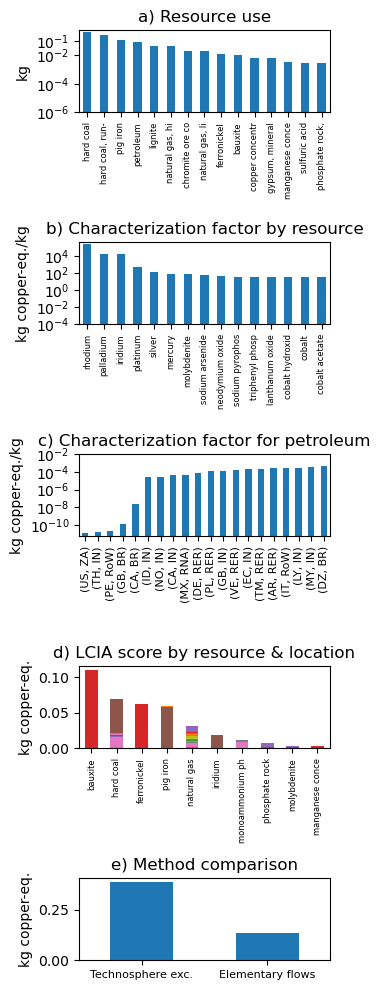

In [24]:
cutoff = 0.00
# remove rows for which "amount" is below the cutoff
m = df_table.loc[df_table["impact"] > 0, "impact"].max()
df = df_table[df_table["impact"] > cutoff * m]
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(3.5, 10))
df_net = df.copy()
d = df_net.groupby(["supplier reference product"])
d = d.sum().sort_values(by="amount", ascending=False)
d["amount"].head(15).plot(kind="bar", ax=axes[0], xlabel='')
axes[0].set_yscale('log')
axes[0].set_title("a) Resource use")
axes[0].set_ylabel("kg")
axes[0].set_xticklabels(
    [x.get_text()[:15] for x in axes[0].get_xticklabels()],
    rotation=90,
)
axes[0].tick_params(axis="x", labelsize=6)
axes[0].set_yticks([1e-6, 1e-4, 1e-2, 1e-1,])
d["CF"] = d["impact"] / d["amount"]
d["CF"].sort_values(ascending=False).head(15).plot(kind="bar", ax=axes[1], xlabel='')
axes[1].set_yscale('log')
axes[1].set_title("b) Characterization factor by resource")
axes[1].set_ylabel("kg copper-eq./kg")
axes[1].set_xticklabels(
    [x.get_text()[:15] for x in axes[1].get_xticklabels()],
    rotation=90,
)
axes[1].tick_params(axis="x", labelsize=6)
axes[1].set_yticks([1e-4, 1e-2, 1e-0, 1e+2, 1e+4])
df_net["CF"] = df_net["impact"] / df_net["amount"]
df_net.replace("Europe without Switzerland", "RER", regex=True, inplace=True)
df_net = df_net.loc[df_net["supplier location"] != df_net["consumer location"]]
df_net = df_net.drop_duplicates(subset=["supplier location", "consumer location"], keep='first')
df_net = df_net.loc[df_net["supplier location"] != "RoW"]
df_net = df_net.loc[df_net["supplier location"] != "RoE"]
df_net = df_net.set_index(["supplier location", "consumer location"])
df_net.loc[df_net["supplier reference product"] == "petroleum", "CF"].sort_values(ascending=True).head(20).plot(kind="bar", ax=axes[2], xlabel='')
axes[2].set_yscale('log')
axes[2].set_title("c) Characterization factor for petroleum")
axes[2].set_ylabel("kg copper-eq./kg")
axes[2].tick_params(axis="x", labelsize=8, rotation=90)
axes[2].set_yticks([1e-10, 1e-8, 1e-6, 1e-4, 1e-2,])
# 3. Stacked bar plot for "amount" by "consumer name" and "consumer location"
df.loc[:, "supplier reference product"] = df["supplier reference product"].str.split(", ").str[0]
df_grouped = df.groupby(["supplier reference product", "supplier location"])["impact"].sum().unstack()
df_grouped = df_grouped.dropna(how='all', axis=0).dropna(how='all', axis=1)
df_grouped = df_grouped[df_grouped.sum(axis=1) != 0]
df_grouped = df_grouped.loc[:, df_grouped.sum(axis=0) != 0]
df_grouped = df_grouped[df_grouped.sum(axis=1) > 1e-4]
df_grouped = df_grouped.dropna(how='all', axis=0).dropna(how='all', axis=1)
df_grouped = df_grouped.loc[df_grouped.sum(axis=1).sort_values(ascending=False).index]
df_grouped = df_grouped.loc[:, df_grouped.sum() > 1e-4]
row_order = df_grouped.sum(axis=1).sort_values(ascending=False).index
df_grouped = df_grouped.loc[row_order]
df_grouped.head(10).plot(kind="bar", stacked=True, ax=axes[3], xlabel='')
#axes[3].set_yscale('log')
axes[3].set_title("d) LCIA score by resource & location")
axes[3].set_ylabel("kg copper-eq.")
axes[3].set_xticklabels(
    [x.get_text()[:15] for x in axes[3].get_xticklabels()],
    rotation=90,
)
axes[3].tick_params(axis="x", labelsize=6)

axes[3].legend().remove()
axes[3].set_yticks([0.0, 0.05, 0.10])

# New fifth panel - Method comparison
import pandas as pd
method_comparison = pd.DataFrame({
    'Method': ['Paired', 'Elementary flows'],
    'Score': [current_score, alternative_score]
})
method_comparison.plot(x='Method', y='Score', kind='bar', ax=axes[4], xlabel='', legend=False)
axes[4].set_title("e) Method comparison")
axes[4].set_ylabel("kg copper-eq.")
axes[4].set_xticklabels(['Technosphere exc.', 'Elementary flows'], rotation=0)
axes[4].tick_params(axis="x", labelsize=8)

plt.tight_layout(rect=[0, 0, 1, 1])  # leave space at the top for the legend
plt.savefig("figure_2.png", bbox_inches="tight", dpi=150)
plt.show()